# Importing necessary packages and functions

In [1]:
!pip install pm4py
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.7
    Uninstalling torch-sparse-0.6.7:
      Successfully uninstalled torch-sparse-0.6.7
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.7
    Uninstalling torch-cluster-1.5.7:
      Successfully uninstalled torch-cluster-1.5.7
Looking in links: https

In [2]:
import pandas as pd
import time
from datetime import datetime
import numpy as np
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.linalg import fractional_matrix_power

import torch 
import torch.nn as nn
from torch.nn import Parameter
#from torch_geometric.nn.inits import glorot, zeros

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm
from pm4py.objects.conversion.dfg import converter as dfg_conv
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.visualization.dfg import visualizer as dfg_vis_fact
from pm4py.visualization.petrinet import visualizer as pn_vis

In [4]:
# from torch_geometric.nn.inits import glorot, zeros 

#Unable to import above line, so manually copy-pasting the source code

import math

def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)

def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

In [5]:
import bisect
import warnings
from torch._utils import _accumulate
from torch import randperm, default_generator

class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)
        
def random_split(dataset, lengths, generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting the parameters

In [6]:
# # Helpdesk dataset

# path = '/content/drive/My Drive/MSc Dissertation/Data/helpdesk.csv'
# dataset = 'helpdesk'
# save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/helpdesk'
# num_nodes = 9

# BPI dataset

path = '/content/drive/My Drive/MSc Dissertation/Data/bpi_12_w.csv'
dataset = 'bpi'
save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/bpi'
num_nodes = 6 

# # BPI dataset (No Repeats)

# path = '/content/drive/My Drive/MSc Dissertation/Data/bpi_12_w_no_repeat.csv'
# dataset = 'bpiNoRepeat'
# save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/bpi_no_repeat'
# num_nodes = 6 

num_features = 4
showProcessGraph = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cuda'
num_epochs = 100
seed_value = 42
lr_value = 1e-05
weighted_adjacency = True
binary_adjacency = False
laplacian_matrix = False
variant = 'feedforward'

# Data Pre-processing

In [7]:
def generate_features (df,total_activities,num_features):
  lastcase = ''
  firstLine = True
  numlines = 0
  casestarttime = None
  lasteventtime = None
  features = []

  for i,row in df.iterrows():
    t = time.strptime(row[2], "%Y-%m-%d %H:%M:%S")
    if row[0]!=lastcase:
        casestarttime = t
        lasteventtime = t
        lastcase = row[0]
        numlines+=1
    timesincelastevent = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(lasteventtime))
    timesincecasestart = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(casestarttime))
    midnight = datetime.fromtimestamp(time.mktime(t)).replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = datetime.fromtimestamp(time.mktime(t))-midnight
    timediff = 86400 * timesincelastevent.days + timesincelastevent.seconds
    timediff2 = 86400 * timesincecasestart.days + timesincecasestart.seconds
    timediff3 = timesincemidnight.seconds #this leaves only time even occured after midnight
    timediff4 = datetime.fromtimestamp(time.mktime(t)).weekday() #day of the week
    lasteventtime = t
    firstLine = False
    feature_list = [timediff,timediff2,timediff3,timediff4]
    features.append(feature_list)

  df['Feature Vector'] = features
  
  firstLine = True
  NN_features =[]

  for i,row in df.iterrows():
    if firstLine:
      features = np.zeros((total_activities,num_features))
      features[row[1] - 1] = row[3]
      firstLine = False
    else:
      if (row[3][0] == 0):
        features = np.zeros((total_activities,num_features))
        features[row[1] - 1] = row[3]
      else:
        features = np.copy(prev_row_features)
        features[row[1] - 1] = row[3]
    prev_row_features = features
    NN_features.append(features)  
  
  return NN_features

In [8]:
def generate_features_with_quartiles (df,total_activities,num_features):
  lastcase = ''
  firstLine = True
  numlines = 0
  casestarttime = None
  lasteventtime = None
  features = []

  for i,row in df.iterrows():
    t = time.strptime(row[2], "%Y-%m-%d %H:%M:%S")
    if row[0]!=lastcase:
        casestarttime = t
        lasteventtime = t
        lastcase = row[0]
        numlines+=1
    timesincelastevent = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(lasteventtime))
    timesincecasestart = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(casestarttime))
    midnight = datetime.fromtimestamp(time.mktime(t)).replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = datetime.fromtimestamp(time.mktime(t))-midnight
    timediff = 86400 * timesincelastevent.days + timesincelastevent.seconds
    timediff2 = 86400 * timesincecasestart.days + timesincecasestart.seconds
    timediff3 = timesincemidnight.seconds #this leaves only time even occured after midnight
    timediff4 = datetime.fromtimestamp(time.mktime(t)).weekday() #day of the week
    lasteventtime = t
    firstLine = False
    feature_list = [timediff,timediff2,timediff3,timediff4]
    features.append(feature_list)

  df['Feature Vector'] = features
  
  firstLine = True
  case_lengths = []
  start_pos = 0

  for i,row in df.iterrows():
    if not firstLine:
      if (row[3][1]==0):
        end_pos = i-1
        for j in range(start_pos,end_pos):
          case_lengths[j]= current_case_length
        start_pos = i
        current_case_length = row[3][1]
        case_lengths.append(current_case_length)
      else:
        current_case_length = row[3][1]
        case_lengths.append(current_case_length)
    else:
      current_case_length = row[3][1]
      case_lengths.append(current_case_length)
      firstLine = False

  end_pos = len(case_lengths) - 1
  for j in range(start_pos,end_pos):
    case_lengths[j]= current_case_length

  df['Case_Length'] = case_lengths

  quartiles = []

  for i,row in df.iterrows():
    if (row[4]!=0):
      temp = float(row[3][1])/ float(row[4])
    else:
      temp = 1
    temp = temp*4.0
    if temp<=1:
      quartiles.append(1)
    elif (temp>1) and (temp<=2):
      quartiles.append(2)
    elif (temp>2) and (temp<=3):
      quartiles.append(3)
    elif (temp>3) and (temp<=4):
      quartiles.append(4)

  df['Quartile'] = quartiles

  firstLine = True
  NN_features =[]

  for i,row in df.iterrows():
    if firstLine:
      features = np.zeros((total_activities,num_features))
      features[row[1] - 1] = row[3]
      firstLine = False
    else:
      if (row[3][0] == 0):
        features = np.zeros((total_activities,num_features))
        features[row[1] - 1] = row[3]
      else:
        features = np.copy(prev_row_features)
        features[row[1] - 1] = row[3]
    prev_row_features = features
    NN_features.append([row['Quartile'],features])  
  
  return NN_features

In [9]:
def generate_labels(df,total_activities):
  next_activity = []
  next_timestamp = []

  for i,row in df.iterrows():
    if (i != 0):
      if (row[3][0]==0):
        next_activity.append(total_activities)
      else:
        next_activity.append(row[1]-1)
  next_activity.append(total_activities)
  for i,row in df.iterrows():
    if (i != 0):
      if (row[3][0]==0):
        next_timestamp.append(0)
      else:
        next_timestamp.append(row[3][2])
  next_timestamp.append(0)

  return next_activity,next_timestamp

In [10]:
class EventLogData(Dataset):
  def __init__ (self, input, output):
    self.X = input
    self.y = output
    self.y = self.y.to(torch.float32)
    self.y = self.y.reshape((len(self.y),1))

  #get the number of rows in the dataset
  def __len__(self):
    return len(self.X)

  #get a row at a particular index in the dataset
  def __getitem__ (self,idx):
    return [self.X[idx],self.y[idx]]
  
  # get the indices for the train and test rows
  def get_splits(self, n_test = 0.33, n_valid = 0.2):
    test_size = round(n_test * len(self.X))
    valid_size = round( n_valid * (len(self.X) - test_size) )
    train_size = len(self.X) - ( test_size + valid_size )
    return random_split(self, [train_size, valid_size, test_size],generator=torch.Generator().manual_seed(seed_value))

In [11]:
def prepare_data_for_Predictor(NN_features,label):
  dataset = EventLogData(NN_features,label)
  train, valid, test = dataset.get_splits()
  train_dl = DataLoader(train, batch_size=1, shuffle = True)
  valid_dl = DataLoader(valid, batch_size=1, shuffle = False)
  test_dl = DataLoader(test, batch_size = 1, shuffle = False)
  return train_dl, valid_dl, test_dl

In [12]:
def generate_input_and_labels (path):
  df = pd.read_csv(path)
  total_unique_activities = num_nodes
  NN_features = generate_features_with_quartiles(df,total_unique_activities,num_features)
  next_activity, next_timestamp = generate_labels(df,total_unique_activities)
  # NN_features = torch.Tensor(NN_features).to(torch.float32)
  next_activity = torch.Tensor(next_activity).to(torch.float32)
  next_timestamp = torch.Tensor(next_timestamp).to(torch.float32)
 
  train_dl, valid_dl, test_dl = prepare_data_for_Predictor(NN_features, next_activity)
  #train_dl, test_dl = prepare_data_for_Predictor(NN_features, next_timestamp)
  
  return train_dl,valid_dl,test_dl

# Getting Adjacency Matrix from Process Graph

In [13]:
def generate_process_graph (path):
  data = pd.read_csv(path)
  num_nodes = data['ActivityID'].nunique() # 9 for helpdesk.csv
  cols = ['case:concept:name','concept:name','time:timestamp']
  data.columns = cols 
  data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])
  data['concept:name'] = data['concept:name'].astype(str)
  log = log_converter.apply(data, variant=log_converter.Variants.TO_EVENT_LOG)
  dfg = dfg_algorithm.apply(log)
  if showProcessGraph:
    visualize_process_graph(dfg,log)
  max = 0
  min = 0
  adj = np.zeros((num_nodes,num_nodes))
  for k,v in dfg.items():
    for i in range(num_nodes):
      if(k[0] == str(i+1)):
        for j in range(num_nodes):
          if (k[1] == str(j+1)):
            adj[i][j] = v
            if (v > max): max=v
            if (v< min): min=v

  print("Raw weighted adjacency matrix: \n {}".format(adj))
  
  # for i in range(num_nodes):
  #   for j in range(num_nodes):
  #     adj[i][j] = (adj[i][j] - min)/(max - min)

  # print("Min-Max normalised weighted adjacency matrix: {}".format(adj))

  if binary_adjacency:
    for i in range(num_nodes):
      for j in range(num_nodes):
        if (adj[i][j]!=0):
          adj[i][j]=1
    print("Binary adjacency matrix: \n {}".format(adj))
  
  D = np.array(np.sum(adj, axis=1))
  D = np.matrix(np.diag(D))
  print("Degree matrix: \n {}".format(adj))
  
  adj = np.matrix(adj)

  if laplacian_matrix:
    adj = D - adj # Laplacian Transform 
    print("Laplacian matrix: \n {}".format(adj))

  # adj = (D**-1)*adj
  adj = fractional_matrix_power(D, -0.5)*adj*fractional_matrix_power(D, -0.5)
  adj = torch.Tensor(adj).to(torch.float)
  
  print("Symmetrically normalised Adjacency matrix: \n {}".format(adj))
  
  return adj

In [14]:
def visualize_process_graph (dfg,log):
  dfg_gv = dfg_vis_fact.apply(dfg, log, parameters={dfg_vis_fact.Variants.FREQUENCY.value.Parameters.FORMAT: "jpeg"})
  dfg_vis_fact.view(dfg_gv)
  dfg_vis_fact.save(dfg_gv,"dfg.jpg")

# Building Model

In [15]:
# class GCNConv(torch.nn.Module):
#     def __init__(self, num_nodes, num_features, out_channels):
#         super(GCNConv, self).__init__()

#         self.in_channels = num_features
#         self.out_channels = out_channels

#         self.weight = Parameter(torch.Tensor(num_features, out_channels))
#         self.bias = Parameter(torch.Tensor(num_nodes))

#         self.reset_parameters()

#     def reset_parameters(self):
#         glorot(self.weight)
#         zeros(self.bias)

#     def forward(self, x, adj):
#         x = adj@x@self.weight
#         x = torch.flatten(x)
#         x = x + self.bias
#         return x

In [16]:
class EventPredictor(torch.nn.Module):
    def __init__(self,num_nodes, num_features = 4):
        super(EventPredictor, self).__init__()

        # self.layer1 = GCNConv(num_nodes, num_features, out_channels=1)
        self.layer2 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(num_nodes * num_features,256),
            nn.Tanh(),
            nn.Linear(256,256),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(256,num_nodes+1),
        )

    def forward(self, x, adj):
        x = torch.flatten(x)
        # x = self.layer1(x,adj)
        x = self.layer2(x)
        # x = torch.sigmoid(x)
        return x

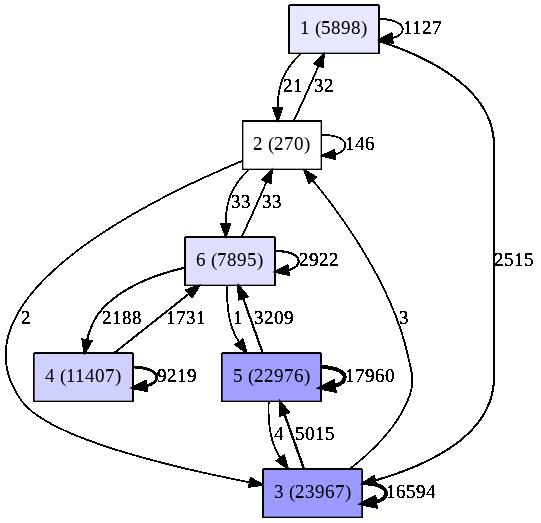

Raw weighted adjacency matrix: 
 [[1.1270e+03 2.1000e+01 2.5150e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.2000e+01 1.4600e+02 2.0000e+00 0.0000e+00 0.0000e+00 3.3000e+01]
 [0.0000e+00 3.0000e+00 1.6594e+04 0.0000e+00 5.0150e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 9.2190e+03 0.0000e+00 1.7310e+03]
 [0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00 1.7960e+04 3.2090e+03]
 [0.0000e+00 3.3000e+01 0.0000e+00 2.1880e+03 1.0000e+00 2.9220e+03]]
Degree matrix: 
 [[1.1270e+03 2.1000e+01 2.5150e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.2000e+01 1.4600e+02 2.0000e+00 0.0000e+00 0.0000e+00 3.3000e+01]
 [0.0000e+00 3.0000e+00 1.6594e+04 0.0000e+00 5.0150e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 9.2190e+03 0.0000e+00 1.7310e+03]
 [0.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00 1.7960e+04 3.2090e+03]
 [0.0000e+00 3.3000e+01 0.0000e+00 2.1880e+03 1.0000e+00 2.9220e+03]]
Symmetrically normalised Adjacency matrix: 
 tensor([[3.0767e-01, 2.3774e-02, 2.8267e-01, 0.0000e+00, 0.0000e+00, 0.0000

In [17]:
model = EventPredictor(num_nodes, num_features)
train_dl,valid_dl,test_dl = generate_input_and_labels(path)
adj = generate_process_graph(path)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=lr_value)
print("************* Event Predictor ***************")
print("Train size: {}, Validation size:{}, Test size: {}".format(len(train_dl.dataset),len(valid_dl.dataset),len(test_dl.dataset)))
print(model)

# Evaluate Model

In [18]:
model = model.to(device)
adj = adj.to(device)

In [19]:
def evaluate_model():
  predictions_1, actuals_1 = list(),list()
  predictions_2, actuals_2 = list(),list()
  predictions_3, actuals_3 = list(),list()
  predictions_4, actuals_4 = list(),list()
  predictions_all, actuals_all = list(),list()

  with torch.no_grad():
    model.eval()

    for i,(inputs,targets) in enumerate(test_dl):
      
      input_quartile = int(inputs[0][0])
      inputs = inputs[1].to(torch.float32)
      
      inputs,targets = inputs.to(device),targets.to(device)

      yhat = model(inputs[0],adj)
      #Retrieving predictions and true values as numpy arrays
      yhat = yhat.to('cpu')
      yhat = torch.argmax(yhat)
      actual = targets.to('cpu')
      actual = actual[0]
      predictions_all.append(yhat)
      actuals_all.append(actual)

      if (input_quartile==1):
        predictions_1.append(yhat)
        actuals_1.append(actual)
      elif (input_quartile==2):
        predictions_2.append(yhat)
        actuals_2.append(actual)
      elif (input_quartile==3):
        predictions_3.append(yhat)
        actuals_3.append(actual)
      elif (input_quartile==4):
        predictions_4.append(yhat)
        actuals_4.append(actual)
      
  #Calculating the accuracy
  acc_1 = accuracy_score(actuals_1, predictions_1)
  acc_2 = accuracy_score(actuals_2, predictions_2)
  acc_3 = accuracy_score(actuals_3, predictions_3)
  acc_4 = accuracy_score(actuals_4, predictions_4)
  acc_all = accuracy_score(actuals_all, predictions_all)

  return acc_1,acc_2,acc_3,acc_4,acc_all

In [21]:
model.load_state_dict(torch.load('/content/EventPredictor_parameters_{}_{}.pt'.format(variant,lr_value),map_location=torch.device(device)))
acc_1,acc_2,acc_3,acc_4,acc_all = evaluate_model()
print("Accuracy for Quartile 1: {}".format(acc_1))
print("Accuracy for Quartile 2: {}".format(acc_2))
print("Accuracy for Quartile 3: {}".format(acc_3))
print("Accuracy for Quartile 4: {}".format(acc_4))
print("Overall Accuracy: {}".format(acc_all))

Accuracy for Quartile 1: 0.7631519016169438
Accuracy for Quartile 2: 0.9018070235254007
Accuracy for Quartile 3: 0.7967551622418879
Accuracy for Quartile 4: 0.4663860766693209
Overall Accuracy: 0.6757616337462337


In [22]:
accuracies = {}

accuracies[1] = acc_1
accuracies[2] = acc_2
accuracies[3] = acc_3
accuracies[4] = acc_4
accuracies['all'] = acc_all

filename = 'accuracyInQuartiles_{}_{}.txt'.format(dataset,variant)
with open(filename, 'w') as f:
    print(accuracies, file=f)

accuracies

{1: 0.7631519016169438,
 2: 0.9018070235254007,
 3: 0.7967551622418879,
 4: 0.4663860766693209,
 'all': 0.6757616337462337}